In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/blast_paper`


In [2]:
using NPZ
using DataInterpolations
using Interpolations
using FastChebInterp
using BenchmarkTools
using Plots
using QuadGK
using LaTeXStrings
using Tullio
using LinearAlgebra

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
Precompiling FileIOExt
  ✓ Qt6ShaderTools_jll
  ✓ Pango_jll
  ✓ Qt6Declarative_jll
  ✓ Plots → FileIOExt
  ✓ Plots → UnitfulExt
  5 dependencies successfully precompiled in 45 seconds. 166 already precompiled.
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
┌ Warning: Module Plots with build ID fafbfcfd-e3aa-1065-0004-134b4d0d6aee is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c].
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
┌ Warning: Module Plots with build ID fafbfcfd-e3aa-1065-0004-134b4d0d6aee is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is im

# _Blast.jl_: reproducing N5K challenge results

In this notebook, I'll show Blast's API in practice. I will go through the computation of the $C_\ell$'s using the N5K challenge window functions, and show that the result matches the benchmark evaluation.

In [3]:
using Revise
using Blast
using blast_tutorials

[ Info: Precompiling UnitfulExt [0e51ec96-f580-5f12-a625-1297083d7970]
┌ Warning: Module Plots with build ID fafbfcfd-e3aa-1065-0004-134b4d0d6aee is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing UnitfulExt [0e51ec96-f580-5f12-a625-1297083d7970].


## Step 1: Load N5K data

In [4]:
#Background quantities
z_b = npzread("data/background/z.npy")
χ = npzread("data/background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [5]:
#3D matter power spectrum
pk_dict = npzread("data/pk.npz")
Pklin = pk_dict["pk_lin"]
Pknonlin = pk_dict["pk_nl"]
k = pk_dict["k"]
z = pk_dict["z"];

In [6]:
#Interpolating the power spectrum
#Linear P(k)
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, (x, y))
InterpPmm = Interpolations.extrapolate(InterpPmm, Line())

#Non-linear P(k)
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm_nl = Interpolations.interpolate(log10.(Pknonlin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm_nl = scale(InterpPmm_nl, x, y)
InterpPmm_nl = Interpolations.extrapolate(InterpPmm_nl, Line())

#Callables
power_spectrum(k, χ1, χ2) = @. sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)))
power_spectrum_nl(k, χ1, χ2) = @. sqrt(10^InterpPmm_nl(z_of_χ(χ1),log10(k)) * 10^InterpPmm_nl(z_of_χ(χ2),log10(k)));

In [7]:
#N5K benchmarks
dtype = Float64

benchmark_gg = npzread("data/benchmarks_nl_full_clgg.npz")
benchmark_ll = npzread("data/benchmarks_nl_full_clss.npz")
benchmark_gl = npzread("../PhD_Stuff/N5K/tests/benchmarks_nl_full_clgs.npz")

#Extracting C_ℓ
gg = dtype.(benchmark_gg["cls"])
ll = dtype.(benchmark_ll["cls"])
gl = dtype.(benchmark_gl["cls"])
ell = dtype.(benchmark_gg["ls"])

#Reshaping them into the same Blast's format
gg_reshaped = zeros( dtype, length(ell), 10, 10)
counter = 1

for i in 1:10
    for j in i:10
        gg_reshaped[:,i,j] = gg[counter, :]
        gg_reshaped[:,j,i] = gg_reshaped[:,i,j]
        counter += 1
    end
end

ll_reshaped = zeros(dtype, length(ell), 5, 5)
counter = 1

for i in 1:5
    for j in i:5
        ll_reshaped[:,i,j] = ll[counter, :]
        ll_reshaped[:,j,i] = ll_reshaped[:,i,j]
        counter += 1
    end
end

gl_reshaped = zeros( dtype, length(ell), 10, 5)
counter = 1

for i in 1:10
    for j in 1:5
        gl_reshaped[:,i,j] = gl[counter, :]
        counter += 1
    end
end

## Using _Blast.jl_

When loading the module, some precomputed $\tilde{T}_\ell$ are already available, alongside the list of the corresponding $\ell$ values. $\tilde{T}_\ell$ are defined as:  $$\tilde{T}_{n ; \ell}^{\mathrm{AB}}\left(\chi_1, \chi_2\right) \equiv \int_{k_{\min }}^{k_{\max }} \mathrm{d} k f^{\mathrm{AB}}(k) T_n(k) j_{\ell}\left(k \chi_1\right) j_{\ell}\left(k\chi_2\right)$$
with:
$$f^{\mathrm{AB}}(k)= \begin{cases}k^2 & \mathrm{AB}=g g, \\ 1 / k^2 & \mathrm{AB}=s s, \\ 1 & \mathrm{AB}=g s.\end{cases}$$

In [8]:
T_LL = Blast.T_tilde_p2
T_CL = Blast.T_tilde_0
T_CC = Blast.T_tilde_m2;

In [9]:
print("Shape of the precomputed T̃: ", size(T_LL))

Shape of the precomputed T̃: (22, 96, 48, 120)

The dimensions correspond to: (nℓ, nχ, nR, nk):
- nℓ is the number of multipoles in which the integral has been evaluated
- nχ is the number of points in χ. Currently, T̃ have been evaluated on a grid χ = LinRange(26, 7000, nχ) as prescribed in the N5K challenge.
- nR is the number of points in R = χ₂/χ₁. The grid that has been used is a grid of 48 Chebyshev points in (0,1].
- nk is the number of points in k, which corresponds to the number of Chebyshev polynomials kept in the approximation of the power spectrum. The grid is made of 120 Chebyshev points defined in the interval [$k_{\mathrm{min}}$, $k_{\mathrm{max}}$]. Again, the chosen values matches the N5K challenge requirements.

#### Defining the previously described grids

In [10]:
ℓ = Blast.ℓ
nχ = 96
χ = LinRange(26, 7000, nχ)
R = chebpoints(96, -1, 1)
R = reverse(R[R.>0])
nR = length(R)
kmax = 200/13 
kmin = 2.5/7000
n_cheb = 119
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));

### Computing the coefficients of the chebyshev decomposition of the power spectrum

The power spectrum, on the basis of the Chebyshev polynomials, becomes: $$P\left(k, \chi_1, \chi_2 ; \theta\right) \approx \sum_{n=0}^{n_{\max }} c_n\left(\chi_1, \chi_2 ; \theta\right) T_n(k)$$
The coefficients of the decomposition are obtained through FFTs.

In [11]:
cheb_coeff = zeros(nχ, nR, n_cheb+1)
#Blast allows you to use FFT plans (in the FFTW fashion). In this way, the heaviest part of the computation is performed only once.
plan = Blast.plan_fft(power_spectrum.(10 .^ k_cheb,χ[1],χ[1]*R[1]),1) 

for i in 1:nR 
    for j in 1:nχ
        cheb_coeff[j,i,:] = Blast.fast_chebcoefs(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R[i]), plan); 
    end
end

In [12]:
@benchmark Blast.plan_fft(power_spectrum.(10 .^ k_cheb,χ[1],χ[1]*R[1]),1)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  152.000 μs …  13.328 ms  ┊ GC (min … max): 0.00% … 91.11%
 Time  (median):     167.208 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   180.112 μs ± 381.723 μs  ┊ GC (mean ± σ):  6.65% ±  3.10%

       ▁            ▁▃▅▆█▇▆▄▂▂                                   
  ▁▂▄▆▇██▆▄▄▄▃▂▂▂▃▄▇███████████▇▇▅▄▄▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  152 μs           Histogram: frequency by time          193 μs <

 Memory estimate: 250.06 KiB, allocs estimate: 1585.

In [13]:
@benchmark Blast.fast_chebcoefs(power_spectrum.(10 .^ k_cheb,χ[1],χ[1]*R[1]), plan)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  203.458 μs …  13.595 ms  ┊ GC (min … max): 0.00% … 95.33%
 Time  (median):     432.208 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   489.653 μs ± 441.048 μs  ┊ GC (mean ± σ):  2.67% ±  3.40%

    ▂▃▃▁ ▂▂▃▅▇██▇▆▅▄▄▄▃▂▃▂▁▂▁▁ ▁▁▁                              ▂
  ▄▆████████████████████████████████▇██▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▄▅▅▆▆▆▅▆ █
  203 μs        Histogram: log(frequency) by time       1.22 ms <

 Memory estimate: 267.00 KiB, allocs estimate: 1841.

_Note: this is not optimal use of Blast, obtaining the Chebyshev coefficients will be a one liner when using a normal power spectrum and not N5K data!_

### Performing the inner k integral

The core part of the algorithm is performing the inner k integral: $$\int_0^{\infty} \mathrm{d} k\, k^2 P_{\mathrm{AB}}(k, \chi_1, \chi_2) \frac{j_\ell(k \chi_1) j_\ell(k \chi_2)}{(k \chi_1)^\alpha (k \chi_2)^\beta}$$

After the Chebyshev decompositon of the power spectrum, it becomes: $$w_{\ell}^{\mathrm{AB}}\left(\chi_1, \chi_2 ; \theta\right) \equiv \sum_{n=0}^{n_{\max }} c_n\left(\chi_1, \chi_2 ; \theta\right) \tilde{T}_{n ; \ell}^{\mathrm{AB}}\left(\chi_1, \chi_2\right)$$

In [14]:
w_LL = Blast.w_ell_tullio(cheb_coeff, T_LL)
w_CL = Blast.w_ell_tullio(cheb_coeff, T_CL)
w_CC = Blast.w_ell_tullio(cheb_coeff, T_CC);

In [15]:
@benchmark Blast.w_ell_tullio(cheb_coeff, T_LL)

BenchmarkTools.Trial: 1967 samples with 1 evaluation.
 Range (min … max):  2.190 ms …  11.342 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.384 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.522 ms ± 734.413 μs  ┊ GC (mean ± σ):  0.85% ± 4.05%

   ▃█▆▂                                                        
  ▄████▇▆▅▅▄▄▃▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▂▂▂▂▁▂▂▂▁▂▂▂▂▂▁▂▁▁▁▁▁▂▂▁▁▂▁▁▁▂▂▂ ▃
  2.19 ms         Histogram: frequency by time        5.23 ms <

 Memory estimate: 798.00 KiB, allocs estimate: 109.

## Computing the integration kernels

#### Step 1: defining background quantities 
This is not showing the optimal usage of Blast, but how to make the $C_\ell$'s match to the N5K challenge benchmarks using the precomputed quantites as showed in the paper (https://arxiv.org/abs/2410.03632). 

In [16]:
cosmo = Blast.FlatΛCDM()
grid = Blast.CosmologicalGrid(z_range = z_of_χ.(Array(χ)))
bg = Blast.BackgroundQuantities(Hz_array = zeros(nχ), χz_array = Array(χ));

In [17]:
# Load N5K n(z), needed to compute lensing and clustering kernels
n5k_bins = npzread("data/dNdzs_fullwidth.npz")

Dict{String, Array{Float64}} with 4 entries:
  "dNdz_cl" => [9.51877e-8 1.11093e-13 … 5.97529e-61 6.25179e-67; 1.246e-7 1.56…
  "z_sh"    => [0.00583333, 0.00757837, 0.00932341, 0.0110684, 0.0128135, 0.014…
  "dNdz_sh" => [0.106801 1.52148e-9 … 6.04656e-24 7.57113e-34; 0.111443 1.76706…
  "z_cl"    => [0.00583333, 0.00757837, 0.00932341, 0.0110684, 0.0128135, 0.014…

##### Computing the kernel

As shown below, Blast is able to compute the kernels, that match the N5K pre-computed ones up to a normalization.

In [18]:
GalKernels = Blast.GalaxyKernel(10, length(grid.z_range))
Blast.compute_kernel!(n5k_bins["dNdz_cl"]',  n5k_bins["z_cl"], GalKernels, grid, bg, cosmo)

In [19]:
ShearKernels = Blast.ShearKernel(4, length(grid.z_range))
Blast.compute_kernel!(n5k_bins["dNdz_sh"]', n5k_bins["z_sh"], ShearKernels, grid, bg, cosmo)

In [20]:
#Loading the N5K pre-computed kernel to check that they match!
W = npzread("data/kernels_fullwidth.npz")

Dict{String, Array{Float64}} with 6 entries:
  "chi_cl"     => [25.9606, 33.7127, 41.4584, 49.1976, 56.9303, 64.6566, 72.376…
  "kernels_sh" => [6.04145e-7 7.78856e-7 … 0.0 0.0; 6.14932e-7 7.9704e-7 … 0.0 …
  "z_sh"       => [0.00583333, 0.00757837, 0.00932341, 0.0110684, 0.0128135, 0.…
  "chi_sh"     => [25.9606, 33.7127, 41.4584, 49.1976, 56.9303, 64.6566, 72.376…
  "kernels_cl" => [0.0 1.02182e-10 … 0.0 0.0; 0.0 9.54391e-17 … 0.0 0.0; … ; 0.…
  "z_cl"       => [0.00583333, 0.00757837, 0.00932341, 0.0110684, 0.0128135, 0.…

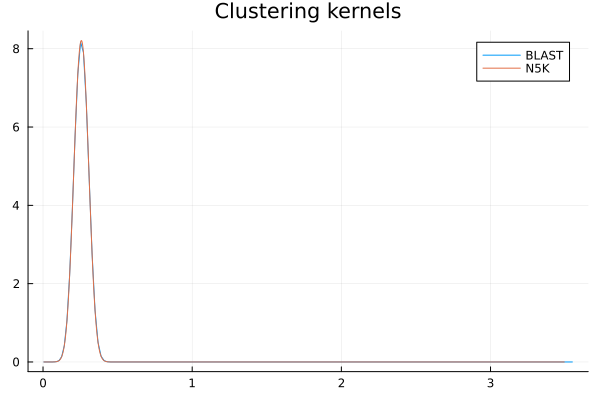

In [21]:
i_bin = 1

interp = DataInterpolations.AkimaInterpolation( W["kernels_cl"][i_bin,:], W["z_cl"], extrapolate = true)
intn, _ = quadgk(x -> interp.(x), 0., 3.5)

interp = DataInterpolations.AkimaInterpolation( GalKernels.Kernel[i_bin,:], grid.z_range, extrapolate = true)
intb, _ = quadgk(x -> interp.(x), 0., 3.5)

plot(grid.z_range, GalKernels.Kernel[i_bin,:]/intb, label="BLAST", title = "Clustering kernels")
plot!(W["z_cl"], W["kernels_cl"][i_bin,:]/intn, label="N5K")

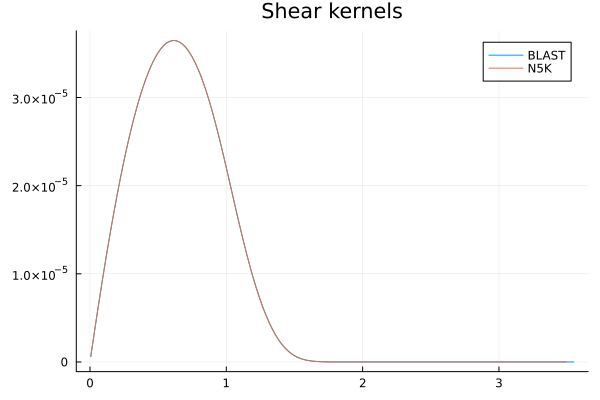

In [22]:
bin = 4

plot(grid.z_range, ShearKernels.Kernel[bin,:], label="BLAST", title = "Shear kernels")
plot!(W["z_sh"], W["kernels_sh"][bin,:], label="N5K")

#### Finally, compute the Cℓ

The module blast_tutorial contains the functions that were specifically developed to work with the N5K inputs and were not included in the official module.

In [23]:
K_CC, K_CL, K_LL = blast_tutorials.compute_kernels(W, χ, R)
w_χ = Blast.simpson_weight_array(nχ)
w_R = Blast.get_clencurt_weights_R_integration(2*nR+1)
pref_CC = Blast.get_ell_prefactor(GalKernels, GalKernels, ℓ)
pref_CL = Blast.get_ell_prefactor(ShearKernels, GalKernels, ℓ)
pref_LL = Blast.get_ell_prefactor(ShearKernels, ShearKernels, ℓ);

In [24]:
clustering_Cℓ = Blast.compute_Cℓ(w_CC, K_CC, bg, w_χ, w_R, pref_CC)
shear_Cℓ = Blast.compute_Cℓ(w_LL, K_LL, bg, w_χ, w_R, pref_LL)
cross_Cℓ = Blast.compute_Cℓ(w_CL, K_CL, bg, w_χ, w_R, pref_CL);

In [25]:
@benchmark Blast.compute_Cℓ(w_CC, K_CC, bg, w_χ, w_R, pref_CC)

BenchmarkTools.Trial: 4496 samples with 1 evaluation.
 Range (min … max):  603.500 μs … 235.536 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     802.458 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.106 ms ±   3.928 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅█▇▅▄▂▁▁▁                                                     ▁
  ███████████▇█▇▆▆▆▆▆▇▅▃▄▄▄▆▄▅▃▄▃▄▅▄▃▄▃▄▃▁▃▄▄▁▁▃▃▁▁▃▁▁▃▄▁▁▁▄▁▁▃ █
  604 μs        Histogram: log(frequency) by time       6.77 ms <

 Memory estimate: 24.56 KiB, allocs estimate: 125.

To match the N5K $C_\ell$'s, we treat the linear, $P_{\mathrm{lin}}(k)$, and non-linear, $P_{\delta}(k)$, matter power spectrum as two separate components and perform the splitting: $$P_\delta\left(k, \chi_1, \chi_2\right)=P_{\operatorname{lin}}\left(k, \chi_1, \chi_2\right)+\left[P_\delta-P_{\operatorname{lin}}\right]\left(k, \chi_1, \chi_2\right)$$
For the linear component, we performed the Chebyshev decomposition as defined before and used that approximation to evaluate the non-Limber angular power spectrum. The non-linear part, on the other hand, is only relevant on small scales, where the Limber approximationis sufficiently accurate. In the following cell, I am loading the $C_\ell$'s computed in the same $\ell$ points, but using the Limber approximation. The functions used to obtain them are included in the blast_tutorial module for completeness.

In [26]:
Cℓ_CC_limb = dtype.(npzread("data/Limber/Cl_CC_limber_linear_full.npy"))
Cℓ_CL_limb =  dtype.(npzread("data/Limber/Cl_CL_limber_linear_full.npy"))
Cℓ_LL_limb =  dtype.(npzread("data/Limber/Cl_LL_limber_linear_full.npy"))
Cℓ_CC_limb_nl = dtype.(npzread("data/Limber/Cl_CC_limber_nl_full.npy"))
Cℓ_CL_limb_nl = dtype.(npzread("data/Limber/Cl_CL_limber_nl_full.npy"))
Cℓ_LL_limb_nl = dtype.(npzread("data/Limber/Cl_LL_limber_nl_full.npy"));

In [27]:
final_clustering_Cℓ = clustering_Cℓ + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_cross_Cℓ = cross_Cℓ + Cℓ_CL_limb_nl - Cℓ_CL_limb
final_shear_Cℓ = shear_Cℓ + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In the challenge, the $C_\ell$'s are evaluated in the range $2<\ell<2000$. After $\ell = 200$, the Limber approximation is accurate enough. We evaluated the $C_\ell$'s in a set of $\ell$ points which are $100$ Chebyshev points defined in the interval of interest. With this choice, we are able to interpolate using, once again, the Chebyshev polynomials and put our angular power spectra on the same N5K $\ell$ grid.

In [28]:
### add Limber Cl's in chebyshev points for l>200
Cℓ_CC_limb = dtype.(npzread("data/Limber/Cl_CC_limber+200_full.npy"))
Cℓ_CL_limb = dtype.(npzread("data/Limber/Cl_CL_limber+200_full.npy"))
Cℓ_LL_limb = dtype.(npzread("data/Limber/Cl_LL_limber+200_full.npy"))
total_Cℓ_CC = cat(final_clustering_Cℓ, Cℓ_CC_limb, dims=1)
total_Cℓ_CL = cat(final_cross_Cℓ, Cℓ_CL_limb, dims=1)
total_Cℓ_LL = cat(final_shear_Cℓ, Cℓ_LL_limb, dims=1);

In [29]:
# Interpolating to go on the same n5k grid
elle = dtype.(reverse(chebpoints(100, 2, 2000)))
ℓ_min = 2
ℓ_max = 2000

interp_Cℓ_CC = zeros(dtype, length(ell), 10, 10)
interp_Cℓ_CL = zeros(dtype, length(ell), 10, 5)
interp_Cℓ_LL = zeros(dtype, length(ell), 5, 5)

for i in 1:10
    for j in i:10
        interpol = chebinterp(reverse(total_Cℓ_CC[:,i,j].*elle.*elle), ℓ_min, ℓ_max)
        interp_Cℓ_CC[:,i,j] = interpol.(ell) ./ (ell.*ell)
        interp_Cℓ_CC[:,j,i] = interp_Cℓ_CC[:,i,j]
    end
end

for i in 1:10
    for j in 1:5
        interpol = chebinterp(reverse(total_Cℓ_CL[:,i,j].*elle.*elle),ℓ_min, ℓ_max)
        interp_Cℓ_CL[:,i,j] = interpol.(ell) ./ (ell.*ell)
    end
end

for i in 1:5
    for j in i:5
        interpol = chebinterp(reverse(total_Cℓ_LL[:,i,j].*elle.*elle), ℓ_min, ℓ_max)
        interp_Cℓ_LL[:,i,j] = interpol.(ell) ./ (ell.*ell)
        interp_Cℓ_LL[:,j,i] = interp_Cℓ_LL[:,i,j]
    end
end

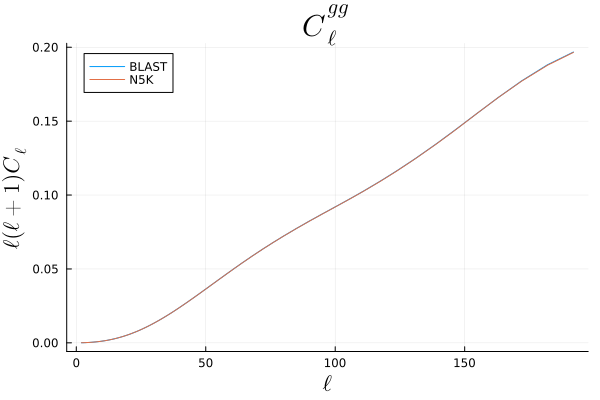

In [30]:
i = 10
j = 10
nl = 60 #set this to 103 to see up to ℓ=2000.
plot(ell[1:nl], interp_Cℓ_CC[1:nl,i,j] .* ell[1:nl] .* (ell[1:nl] .+1), label="BLAST", title = L"$C_\ell^{gg}$", titlefontsize=20, 
    xlabel=L"$\ell$", ylabel=L"$\ell(\ell+1)C_\ell$", labelfontsize=15)
plot!(ell[1:nl], gg_reshaped[1:nl,i,j] .* ell[1:nl] .* (ell[1:nl] .+1), label = "N5K")

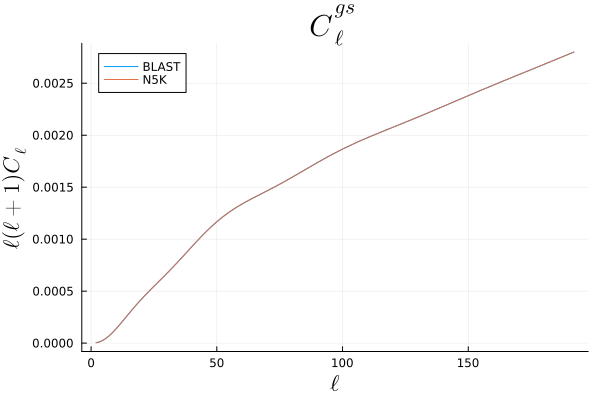

In [31]:
i = 1
j = 2
nl = 60 #set this to 103 to see up to ℓ=2000.
plot(ell[1:nl], interp_Cℓ_CL[1:nl,i,j] .* ell[1:nl] .* (ell[1:nl] .+1), label="BLAST", title = L"$C_\ell^{gs}$", titlefontsize=20, 
    xlabel=L"$\ell$", ylabel=L"$\ell(\ell+1)C_\ell$", labelfontsize=15)
plot!(ell[1:nl], gl_reshaped[1:nl,i,j] .* ell[1:nl] .* (ell[1:nl] .+1), label = "N5K")

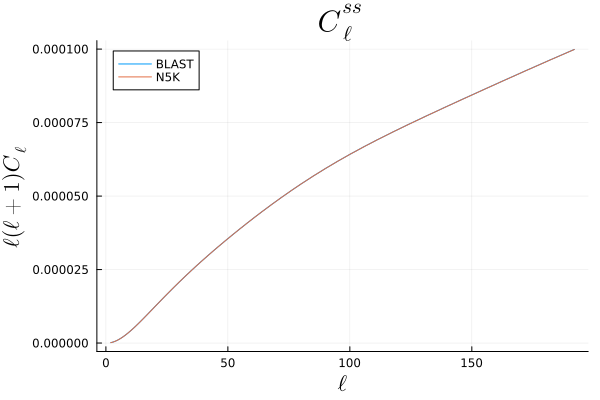

In [32]:
i = 3
j = 3
nl = 60 #set this to 103 to see up to ℓ=2000.
plot(ell[1:nl], interp_Cℓ_LL[1:nl,i,j] .* ell[1:nl] .* (ell[1:nl] .+1), label="BLAST", title = L"$C_\ell^{ss}$", titlefontsize=20, 
    xlabel=L"$\ell$", ylabel=L"$\ell(\ell+1)C_\ell$", labelfontsize=15)
plot!(ell[1:nl], ll_reshaped[1:nl,i,j] .* ell[1:nl] .* (ell[1:nl] .+1), label = "N5K")

### Computing the Δχ²

In [33]:
N_b = get_nmodes_fullsky(ell)
Nb_final = sqrt.(N_b) * 0.4;

As in the N5K challenge paper, the accuracy metric is defined as: $$\Delta \chi^2 \equiv \sum_b N_b \operatorname{Tr}\left(\Sigma_b^{-1} \Delta C_b\right)^2$$
$\Delta C_b$ is the difference between the computed $C_\ell$'s and the benchmark. $N_b$ is the effective number of modes in that specific bandpower, $\Sigma$ is a 15 × 15 matrix containing the benchmark $C_\ell$'s in bandpower b and the LSST shape-noise and shot-noise terms.

The challenge requirement is $\Delta \chi^2 < 0.2$

In [34]:
nl = 60 
Cℓ_matrix = zeros(dtype, nl, 15, 15)
CC = interp_Cℓ_CC[1:nl,:,:] 
CL = interp_Cℓ_CL[1:nl,:,:]
LL = interp_Cℓ_LL[1:nl,:,:]

Cℓ_matrix[:,1:5,1:5] = LL
Cℓ_matrix[:,6:15,6:15] = CC
Cℓ_matrix[:, 1:5, 6:15] = permutedims(CL, (1,3,2))
Cℓ_matrix[:, 6:15, 1:5] = CL;

In [35]:
Cℓ_N5K = zeros(dtype, nl, 15, 15)

Cℓ_N5K[:,1:5,1:5] = ll_reshaped[1:nl,:,:]
Cℓ_N5K[:,6:15,6:15] = gg_reshaped[1:nl,:,:]
Cℓ_N5K[:, 1:5, 6:15] = permutedims(gl_reshaped[1:nl,:,:], (1,3,2))
Cℓ_N5K[:, 6:15, 1:5] = gl_reshaped[1:nl,:,:];

In [36]:
ΔC = Cℓ_matrix .- Cℓ_N5K;

In [37]:
Σ_CC, Σ_LL, Σ_CL =  Σ(gg_reshaped[1:nl,:,:], ll_reshaped[1:nl,:,:], gl_reshaped[1:nl,:,:], ell[1:nl], dtype, 0.4);

In [38]:
Σ_matrix = zeros(dtype, nl, 15, 15)

Σ_matrix[:,1:5,1:5] = Σ_LL
Σ_matrix[:,6:15,6:15] = Σ_CC
Σ_matrix[:, 1:5, 6:15] = permutedims(Σ_CL, (1,3,2))
Σ_matrix[:, 6:15, 1:5] = Σ_CL;

In [39]:
Σ_inv = zeros(dtype, nl, 15, 15)

for l in 1:nl
    Σ_inv[l,:,:] = inv(Σ_matrix[l,:,:])
end

In [40]:
bandpowers = Nb_final[1:nl];

In [41]:
@tullio Δχ2 :=  Σ_inv[l,i,j] * ΔC[l,j,k] * Σ_inv[l,k,m] * ΔC[l,m,i] * bandpowers[l]

0.09798202517583868

In [42]:
Δχ2 < 0.2

true